# Classifying Heart Disease Via Logistic Regression

## Introduction
---
With this project we attempt to build a logistic regression model that is successful at predicting whether a patient has developed a heart disease or not, based on the patient's medical history. 

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import zscore

## Data Set Description 
---
Attribute Information ([source](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)):

- `age`: age in years.


- `sex`:
    - 1 = male
    - 0 = female


- `cp` - chest pain type:
    - `Value 1`: typical angina.
    - `Value 2`: atypical angina.
    - `Value 3`: non-anginal pain.
    - `Value 4`: asymptomatic.
    
    
- `trestbps`: resting blood pressure (in mm Hg [milliliters of mercury] on admission to the hospital).



- `chol`: serum cholesterol in mg/dl (levels in milligrams per deciliter).


- `fbs` - (fasting blood sugar > 120 mg/dl):
    - `0` = false.
    - `1` = true.

    This test measures sugar (glucose) in the blood:
        - 99 mg/dL or lower: This is a normal fasting blood sugar level.
        - 100–125 mg/dL: Fasting blood sugar in this range typically indicates prediabetes. 
        - 126 mg/dL or above: This indicates high blood sugar, the main sign of diabetes.


- `restecg` - resting electrocardiographic results:
    - `Value 0`: normal.
    - `Value 1`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV).
    - `Value 2`: showing probable or definite left ventricular hypertrophy by Estes' criteria.
    
    
    
- `thalach` - maximum heart rate achieved.


- `exang` - exercise induced angina: 
    - 1 = yes.
    - 0 = no.
    
    
- `oldpeak` = [ST depression](https://en.wikipedia.org/wiki/ST_depression) induced by exercise relative to rest (mm).


- `slope` - the slope of the peak exercise ST segment:
    - `Value 1`: upsloping.
    - `Value 2`: flat.
    - `Value 3`: downsloping.
    
    
    
- `ca`: number of major vessels (0-3) colored by fluoroscopy.



- `thal` - presence of thalassemia (a blood disorder): 
    - 3 = normal.
    - 6 = fixed defect (no blood flow in some part of the heart).
    - 7 = reversible defect (a blood flow is observed but it is not normal).
    
    
    
- `num`/`present` - diagnosis of heart disease (angiographic disease status)
    - `Value 0`: < 50% diameter narrowing.
    - `Value 1`: > 50% diameter narrowing.

## Exploratory Data Analysis
---

In [2]:
heart = pd.read_csv('heart_disease.csv', index_col=0)

heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  present   303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 35.5+ KB


In [3]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


The preliminary assessment of which variables to include in the model is the following:

| Feature  | Maintain         | Comment                                      |
| -------- | ---------------- |--------------------------------------------- |
| age      | yes              | We assume that aging may come with health issues, namely heart disease, cause particularly from a sedentary life style, bad diet and chronic smoking.      |
| sex      | to be determined |                           -                  |
| cp       | yes              | Chest pain may be related with heart disease. |
| trestbps | yes              | -                                            |
| cho      | yes              | -                                            |
| fbs      | yes              | A fasting blood sugar test measures sugar (glucose) in the blood.|
| restecg  | yes              | -                                            |
| thalach  | yes              | -                                            |
| exang    | yes              | -                                            |
| oldpeak  | yes              | -                                            |
| slope    | yes              | -                                            |
| ca       | no               | Without further context, knowing how many major vessels were colored by the flourosopy doesn't have any direct relation with a patient having heart disease or not.                         |
| thal     | yes              | -                                            |

### Preliminary steps:
1. drop `ca`
2. convert the following categorical variables into dummies: 
    - `cp` (chest pain),
    - `restecg` (resting electrocardiographic results),
    - `thal` (presence of thalassemia)
    - `slope` (ST segment slope).
3. analyze box plots of predictors controlling for the target variable classes.

In [4]:
heart =  heart.drop(columns='ca')

cp_dict = {
    1: 'typical_angina',
    2: 'atypical_angina',
    3: 'non-anginal_pain',
    4: 'asymptomatic',
    }

restecg_dict = {
    0: 'normal',
    1: 't_wave_abnormality',
    2: 'ventricular_hypertrophy',
    }

thal_dict = {
    '?': 'inconclusive',
    '3.0': 'normal',
    '6.0': 'fixed_defect',
    '7.0': 'reversible_defect',
    }

slope_dict = {
    1: 'upsloping',
    2: 'flat',
    3: 'downsloping',
    }

heart.cp = heart.cp.map(cp_dict)

heart.restecg = heart.restecg.map(restecg_dict)

heart.thal = heart.thal.map(thal_dict)

heart.slope= heart.slope.map(slope_dict)

Before we turn the categorical variables into dummies we look at their frequency distribution in order to exclude subcategories which have a very small representation (inferior to 5%).

In [5]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',]
categorical = [col for col in heart.columns if col not in numerical]

for col in categorical:
    print(heart[col].value_counts(normalize=True))
    print('---------------------------------------------')

1    0.679868
0    0.320132
Name: sex, dtype: float64
---------------------------------------------
asymptomatic        0.475248
non-anginal_pain    0.283828
atypical_angina     0.165017
typical_angina      0.075908
Name: cp, dtype: float64
---------------------------------------------
0    0.851485
1    0.148515
Name: fbs, dtype: float64
---------------------------------------------
normal                     0.498350
ventricular_hypertrophy    0.488449
t_wave_abnormality         0.013201
Name: restecg, dtype: float64
---------------------------------------------
0    0.673267
1    0.326733
Name: exang, dtype: float64
---------------------------------------------
upsloping      0.468647
flat           0.462046
downsloping    0.069307
Name: slope, dtype: float64
---------------------------------------------
normal               0.547855
reversible_defect    0.386139
fixed_defect         0.059406
inconclusive         0.006601
Name: thal, dtype: float64
----------------------------------

As we can observe in the values above, `t_wave_abnormality` (`restecg`)  and `inconclusive` (`thal`) are categories that possess a very small representation - under 5%, therefore we exclude the rows associated with these values. Next, we convert all the categorical variables into sets of dummies.

In [6]:
heart = heart.query('restecg != "t_wave_abnormality" & thal != "inconclusive"')

heart = (
    pd.get_dummies(
        data=heart,
        columns=['cp', 'restecg', 'thal', 'slope']
    )
    .drop(
        columns=['restecg_normal', 'cp_asymptomatic', 'thal_normal', 'slope_upsloping']
    )
)

Checking `heart` after the modifications made so far.

In [7]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 1 to 303
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              297 non-null    int64  
 1   sex                              297 non-null    int64  
 2   trestbps                         297 non-null    int64  
 3   chol                             297 non-null    int64  
 4   fbs                              297 non-null    int64  
 5   thalach                          297 non-null    int64  
 6   exang                            297 non-null    int64  
 7   oldpeak                          297 non-null    float64
 8   present                          297 non-null    int64  
 9   cp_atypical_angina               297 non-null    uint8  
 10  cp_non-anginal_pain              297 non-null    uint8  
 11  cp_typical_angina                297 non-null    uint8  
 12  restecg_ventricular_hy

### Removing outliers.

In order to achieve more accurate predictions we have to assure ourselves that the coefficients aren't biased due to influential observations. To prevent that, we'll be trimming values for non-binary variables that exceed 2 standard deviations. 

In [8]:
all_feats = [col for col in heart.columns if col != 'present']

non_binary = [col for col in heart.columns if len(heart[col].unique()) != 2]
      
non_binary

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

The histograms below show where the trimming will be made.

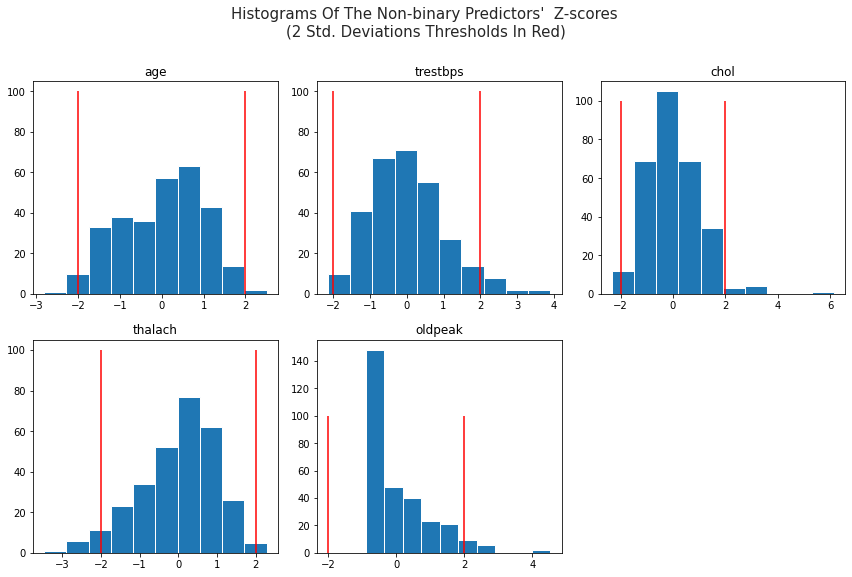

In [54]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

sns.set_theme(context='notebook', style='darkgrid')

plt.suptitle(
    "Histograms Of The Non-binary Predictors'  Z-scores \n(2 Std. Deviations Thresholds In Red)",
    size=15,
    y=1.0
    )

for i in range(0, 5+1):    
    if i < 3:
        ax_ = ax[0, i]
    if 3 <= i < 6:
        ax_ = ax[1, i-3]
    if i <= 6:
        plt.axis('off')
    
    if i < 5:
        col = non_binary[i]
        z_score = zscore(heart[col])
        ax_.hist(z_score)
        std_dev_neg_line = ax_.vlines(-2, ymin=0, ymax=100, color='red')
        std_dev_pos_line = ax_.vlines(2, ymin=0, ymax=100, color='red')
        ax_.set_title(non_binary[i])
        ax_.grid(axis='y', color='w')
        ax_.set_axisbelow(True)
                
plt.tight_layout()
plt.show()

Dropping rows that contain a value with a z-score over 2.

In [31]:
z_scores = zscore(heart[non_binary])

below_2_sdev = z_scores[z_scores < 2].dropna(axis=0)

heart = heart.loc[below_2_sdev.index ,:].reset_index(drop=True)

f'Rows left after trimming outliers: {heart.shape[0]}'

'Rows left after trimming outliers: 263'

### Box plot analysis of non-binary predictors.

For each predictor, we observe its frequency distribution dividing each sample based on the target: the patients without heart disease and those with heart disease.

The units of measurement for each variable is the following:
- `age`: years.
- `trestbps` (resting blood pressure): milligrams of mercury (mm of Hg).
- `chol` (serum cholesterol): milligrams per deciliter (mg/dL).
- `thalach` (maximum heart rate achieved): beats per minute.
- `oldpeak` (ST depression induced by exercise relative to rest): millimiters (mm). 

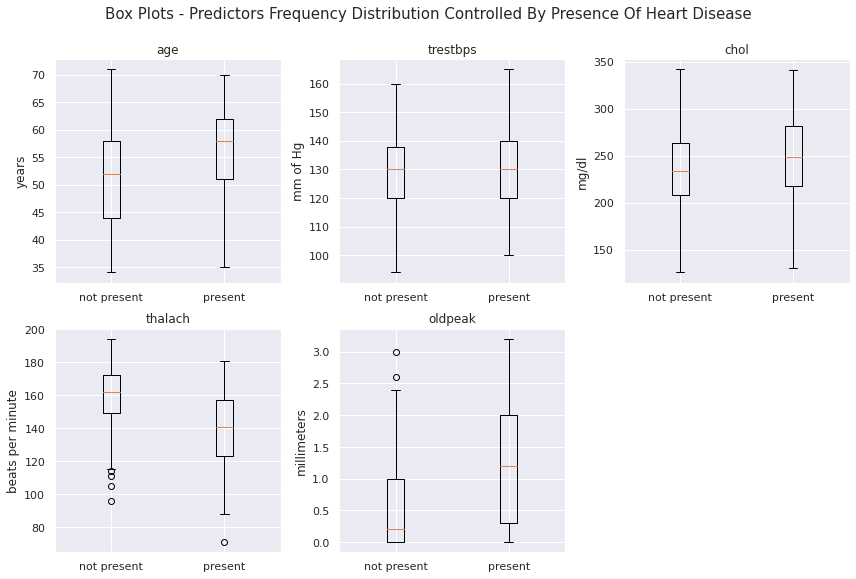

In [32]:
non_binary_labels = ['years', 'mm of Hg', 'mg/dl', 'beats per minute', 'millimeters']

disease = heart.query('present  == 1')
no_disease = heart.query('present  == 0')

fig, ax = plt.subplots(2, 3, figsize=(12, 8))


plt.suptitle(
    'Box Plots - Predictors Frequency Distribution Controlled By Presence Of Heart Disease',
    size=15,
    y=1.0
    )

for i in range(0, 5+1):    
    if i < 3:
        ax_ = ax[0, i]
    if 3 <= i < 6:
        ax_ = ax[1, i-3]
    if i <= 6:
        plt.axis('off')
    
    if i < 5:
        not_present = no_disease[non_binary[i]].values
        present = disease[non_binary[i]].values
        ax_.boxplot([not_present, present])
        ax_.set_xticklabels(['not present', 'present'])
        ax_.set_title(non_binary[i])
        ax_.set_ylabel(non_binary_labels[i])
        ax_.grid(axis='y', color='w')
        ax_.set_axisbelow(True)
        
plt.tight_layout()
plt.show()

- `age`: visually, there seems to be a difference in distribution between samples, where patients with heart disease are older in general: the second quartile starts around 44 years for no heart disease, whereas it starts at around 50 to 55 years when heart disease is present. 


- `trestbps` (resting blood pressure): in this case, the difference between frequency distributions is small, therefore we'll exclude this variable from the model.


- `chol` (serum cholesterol): this variable also shows similar frequency distributions for 'present' and 'note present', therefore we exclude this variable.


- `thalach` (maximum heart rate achieved): in this case we can see a difference in the distributions: the second quartile starts around 145 beats per minute for 'not present', whereas the same quartile starts at a much lower number of beats per minute - around 120.


- `oldpeak` (ST depression induced by exercise relative to rest): this variable also shows a visible difference in frequency distributions: the depression is in general higher for patients with heart disease in comparison with patients without heart disease. 

Dropping `trestbps` and `chol`.

In [33]:
heart = heart.drop(columns=['trestbps', 'chol'])

### Variance Inflation Factor (VIF) analysis.

Next we compute a battery of auxiliary regressions to check for multicollinearity.

In [34]:
features = [col for col in heart.columns if col != 'present']

feats_dict = {
    'all_features': features,
    'no_age': [col for col in features if col not in ['age']],
    'no_thalach': [col for col in features if col not in ['thalach']],
    'no_age_thalach': [col for col in features if col not in ['thalach', 'age']]
             }


# VIF DataFrame.
vif_data = pd.DataFrame(index=heart[features].columns)
  
for feat_set in feats_dict:
    feats = feats_dict[feat_set]
    vif_list = [vif(heart[feats].values, i) for i in range(len(heart[feats].columns))]
    vif_series = pd.Series(vif_list, index=feats, name=feat_set)
    
    vif_data = pd.concat([vif_data, vif_series], axis=1)

vif_data

,all_features,no_age,no_thalach,no_age_thalach
age,22.214873,NaN,7.633492,NaN
sex,4.285920,4.285700,4.046871,3.555346
fbs,1.258244,1.243202,1.250331,1.242887
thalach,20.830412,7.157762,NaN,NaN
exang,1.949113,1.932270,1.949023,1.894054
oldpeak,3.024739,2.886239,2.970573,2.872475
cp_atypical_angina,1.832057,1.831816,1.642824,1.248805
cp_non-anginal_pain,2.121290,2.119531,1.905850,1.397404
cp_typical_angina,1.306528,1.306085,1.276795,1.201608
restecg_ventricular_hypertrophy,2.096428,2.072349,2.078291,1.875032


The model with all the features shows that, when we calculate the VIF for every predictor, there is some evidence of multicollinearity. We consider values above 4 to be a cause of concern and values over 10 to indicate high multicollinearity. The VIF calculations produced when including all features (first column) show that there are at least two cases of high collinearity among predictors: `age` and `thalach`. When recalculating the VIF values without `age` we have a single value over 4 which is for `thalach` - 7.15..; when we exclude `thalach` instead, the only VIF value over 4 is for `age` - 7.63..; when excluding both `age` and `thalach` there are no VIF values over 4. Instead of working with only one group of predictors we'll be estimating logistic regressions for these groups and compare their prediction power.   

## Model Fitting And Prediction 
---
For this analysis we randomly split the train and the test set into 60 and 40% sub-sample sizes, respectively, with a pseudo-random state set at 342.

In [35]:
X = heart[features]

y = heart.present

X_train, X_test, y_train, y_test = split(
    X,
    y,
    test_size=0.4,
    random_state=342
    )

### Part I - Using the train set to fit and make control predictions.

Checking the distribution of `present` in the train and test sets.

In [43]:
pd.DataFrame(
    {
        'train': y_train.value_counts(normalize=True).round(2),
        'test': y_test.value_counts(normalize=True).round(2)
    })

,train,test
0,0.61,0.51
1,0.39,0.49


The distribution of values in the train set is more uneven - 11% more cases of presence of heart disease, than in the test set.

In this section, we not only fit and produce predictions resorting solely to the train set, we calculate the prediction metrics that allow us to assess the predicting qualities of the model, these are: 

- accuracy (overall capability to predict the outcome).
- sensitivity (capability to successfully predict cases of heart disease).
- specificity (capability to successfully predict cases of absence of heart disease).

In [37]:
def log_model(features, X, y):
    logistic = LogisticRegression(max_iter=10000)
    model = logistic.fit(X[features].values, y.values)
    return model

def return_scores(features, model, X, y):
    prediction = model.predict(X[features].values)
    
    # Accuracy.
    accuracy = sum(prediction == y) / y.shape[0]
    accuracy = round(accuracy*100, 2)
    
    # Sensitivity.
    true_positives =  sum((prediction == y) & (prediction == 1))
    false_negatives = sum((prediction != y) & (prediction == 0))
    
    sensitivity = true_positives / (true_positives + false_negatives)
    sensitivity = round(sensitivity*100, 2)
    
    # Specificity.
    true_negatives = sum((prediction == y) & (prediction == 0))
    false_positives = sum((prediction != y) & (prediction == 1))
    
    specificity = true_negatives / (true_negatives + false_positives)
    specificity = round(specificity*100, 2)
    
    results = {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity
    }
    
    return results
    

In [38]:
scores_train_df = pd.DataFrame()

models_dict = {}

for feat_set in feats_dict:
    
    feats = feats_dict[feat_set]
    
    model = log_model(feats, X_train, y_train)
    
    models_dict[feat_set] = model
    
    scores_train = return_scores(feats, model, X_train, y_train)
    
    scores_train_df = pd.concat(
        [scores_train_df, pd.Series(scores_train, name=feat_set)],
        axis=1)
    
scores_train_df

,all_features,no_age,no_thalach,no_age_thalach
accuracy,85.99,84.71,85.35,83.44
sensitivity,78.69,78.69,78.69,75.41
specificity,90.62,88.54,89.58,88.54


As we can see above, all models behave similarly, while the model with all features performing slightly better than the rest, more specifically in terms of accuracy and specificity. If we  If we could choose, we would prefer to have a higher sensitivity rate, rather than a high specificity rate; but in our case we find that in general, specificity rates are much higher - 10% or more, than sensitivity rates. In terms of accuracy, an 80% score in regards to the training set is not indicative of the model being prone to overfitting, therefore, we need to observe the score results for the test set in order to assess it. Given that predictions which include `age` are marginally better than those without, we continue the analysis with the model which does not include the measurement of the maximum heart rate achieved during the electrocardiogram (`no_thalach`).

#### Analyzing the model without  `thalahc` (`no_thalach`). 

In [39]:
log_odds_coefs = models_dict['no_thalach'].coef_[0]

odds_ratio = np.exp(log_odds_coefs)

odds_ratio = pd.Series(
    odds_ratio, 
    index=feats_dict['no_thalach'],
    name='odds_ratio_coeffs'
    )

log_odds = pd.Series(
    log_odds_coefs,
    index=feats_dict['no_thalach'],
    name='log_odds_coeffs'
    )

odds_ratio_percentage = round((odds_ratio - 1)*100, 2)
odds_ratio_percentage.name = 'odds_ratio_percentage'


coeffs = pd.concat(
    [log_odds, odds_ratio, odds_ratio_percentage],
    axis=1
    )

coeffs = coeffs.sort_values('odds_ratio_coeffs', ascending=False)

coeffs

,log_odds_coeffs,odds_ratio_coeffs,odds_ratio_percentage
thal_reversible_defect,1.212366,3.361429,236.14
sex,1.007157,2.737806,173.78
slope_flat,0.785835,2.194238,119.42
thal_fixed_defect,0.698234,2.010199,101.02
restecg_ventricular_hypertrophy,0.660906,1.936545,93.65
exang,0.514400,1.672634,67.26
oldpeak,0.401966,1.494761,49.48
age,0.053812,1.055286,5.53
slope_downsloping,-0.174251,0.840086,-15.99
fbs,-0.232654,0.792428,-20.76


The data frame `coeffs` gives us the log odds and odds ratios for the `no_thalach` model. The DataFrame is sorted by the odds ratio (second column) in descending order. Looking to the odds ratio column we see that only 8 variables are above 1, i.e. these variables increase the chances of heart disease:

- The dummies related with the presence of a blood disorder called thalassemia - `thal_reversible_defect` and `thal_fixed_defect`, increase 3.36 (236.1%) and 2 times (101%), respectively, the chances of developing heart disease. 


- Next, being male, `sex=1`, increases the chances of heart disease by 173.8%.


 - ST segment slope: down slopping or a flat response of the ST segment during peak exercise (`slope_downsloping` and `slope_flat` respectively) [may indicate heart disease](https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/) but in this model only the latter indicates that, where the presence of a flat ST segment increases the chance of heart disease by 93.7%.


- The dummies related with resting electrocardiographic results (`estecg`) show that if there is evidence of probable or definite left ventricular hypertrophy - `restecg_ventricular_hypertrophy` the chances of developing a heart disease increases 39.9%.


- An exercise induced angina, `exang=1`, increases the chances of heart disease by 67.3%.


- Still on the analysis of the ST segment, the increase of the ST depression induced by exercise (in mm) - `oldpeak`, increases the chances of heart disease by 49.5%.


- Finally, older patients - `age`, are more prone to heart disease by 5.5%. 


Regarding variables that, according to the model, decrease the risk of heart disease, we may dismiss them, since in theory, they may or may not contribute to heart disease, but they are very unlikely to actually decrease the chances of heart disease. In the case of `fbs` there is some [evidence](https://publichealth.jhu.edu/2005/selvin-bloodsugar) that high blood sugar can contribute independently to increasing heart disease risk, thus contradicting the findings. Moreover, variables related to chest pain type (`cp`) - `cp_typical_angina`, `cp_non-anginal_pain`, `cp_atypical_angina`, are expected to have some relation with heart disease, [specially angina related pain](https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373), but the model does not capture that relation. 

### Part II - Calculating test set based predictions and comparing them with the train set based predictions.

In [40]:
scores_test_df = pd.DataFrame()

models_dict = {}

for feat_set in feats_dict:
    
    feats = feats_dict[feat_set]
    
    model = log_model(feats, X_train, y_train)
    
    models_dict[feat_set] = model
    
    scores_test = return_scores(feats, model, X_test, y_test)
    
    scores_test_df = pd.concat(
        [scores_test_df, pd.Series(scores_test, name=feat_set)],
        axis=1)
    
scores_test_df

,all_features,no_age,no_thalach,no_age_thalach
accuracy,80.19,80.19,80.19,79.25
sensitivity,84.62,78.85,78.85,75.00
specificity,75.93,81.48,81.48,83.33


The following DataFrame, `compare`, displays the percentage difference obtained by comparing the test set metrics with the train set metrics.

In [41]:
compare = (scores_test_df - scores_train_df) / scores_train_df

compare = compare.round(3)*100

compare

,all_features,no_age,no_thalach,no_age_thalach
accuracy,-6.7,-5.3,-6.0,-5.0
sensitivity,7.5,0.2,0.2,-0.5
specificity,-16.2,-8.0,-9.0,-5.9


From both `scores_test_df` and `compare` (scores) DataFrames, we can see that, in general, the accuracy decreased from the train set prediction around 5 to 6%. Sensitivity increased substantially for the model with all variables whilst roughly maintaining the same values for the other models. In terms of specificity, the best model is now the one without `age` and `thalach`, which registered the smallest reduction in that metric: -5.9%. In regards to the best model, no version has the best values all around. The model with all variables performs better in terms of sensitivity, which is arguably the most important metric, since we are more interested in predicting cases (heart disease) than predicting non-cases (no heart disease); in our, case, the all-features model has a sensitivity score - 84.62%, which is even superior to the accuracy score. Conversely, the model chosen as reference - the model without maximum heart rate - `no_thalach`, performs substantially worst than the all-features model by almost 5.8%, when comparing the test set sensitivity metrics. Conversely, the former model actually performs much worst than the latter model (all features) in terms of specificity, by a difference of 5.5%. 




## Conclusion
---
Overall, these models seem to predict well the target's behavior and we can also attest that the predictions made via test set were high but inferior to those produced via train set, which indicates us that the model is not overfitting nor heavily underfitting. In terms of assessing how good these models are in predicting heart disease it is necessary to compare their prediction score results to those withdrawn from professional studies, where we can have a sense of what is the expected level of prediction power. Regardless, we were able to obtain accuracy and sensitivity score results for the test sets that were over 80%. The question of which model should be used as the reference is differed to an extended analysis on the original variables, in order to assess whether the numeric independent variables are linear (e.g. by checking the statistical significance of the interaction terms), and also to try to detect and remove influential outliers that weren't spotted (e.g. resorting to the cook's distance). Fitting and computing predictions using another data set with the same variables, or conducting a cross-validation analysis, could also shed some light on the robustness of their prediction power.
